In [1]:
import json
import keras
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from training_data_generation import model_ready_data
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from bayes_opt import BayesianOptimization

# Data Analysis

In [2]:
df = pd.read_csv("data/train_data.csv")

In [3]:
df.head()

,rsi_5,rsi_5-1,rsi_5-5,rsi_5-20,rsi_14,rsi_14-1,rsi_14-5,rsi_14-20,rsi_30,rsi_30-1,...,adx_30-20,close_price,high_price,low_price,date,total_revenue,revenue_per_share,1d,5d,20d
0,53.095356,64.157989,75.573446,62.911868,62.825979,66.700784,70.418795,56.183486,61.249205,62.911737,...,1460.627531,145.582855,147.844979,145.393512,2024-03-18 00:00:00-04:00,6591000064,22.533,0.008899,-0.003628,-0.062070
1,23.523554,35.167644,57.288642,91.104898,45.535378,51.372333,60.416295,72.990983,53.408498,56.213974,...,1730.398337,141.078171,144.990907,140.868568,2024-04-04 00:00:00-04:00,6591000064,22.533,0.019669,0.025895,-0.027027
2,84.988019,80.916269,74.606227,16.623494,70.101517,67.190952,57.193581,34.380161,62.112529,60.317265,...,1753.408547,153.794571,154.263701,152.227472,2024-05-15 00:00:00-04:00,6591000064,22.533,0.001493,-0.007853,-0.152583
3,60.437385,28.427980,21.007312,40.590883,48.490119,35.835017,37.720252,57.543973,50.888402,45.348900,...,2223.930239,138.942139,139.391302,135.758045,2024-04-23 00:00:00-04:00,6591000064,22.533,-0.012284,-0.015517,0.103951
4,45.016102,43.973284,84.531400,53.666856,59.759175,59.564562,70.129567,46.565516,58.054938,57.967834,...,2390.363024,150.380920,151.179442,149.282952,2024-05-24 00:00:00-04:00,6591000064,22.533,-0.016262,-0.127838,-0.106000


In [18]:
df.columns

Index(['rsi_5', 'rsi_5-1', 'rsi_5-5', 'rsi_5-20', 'rsi_14', 'rsi_14-1',
       'rsi_14-5', 'rsi_14-20', 'rsi_30', 'rsi_30-1', 'rsi_30-5', 'rsi_30-20',
       'ma_5', 'ma_5-1', 'ma_5-5', 'ma_5-20', 'ma_20', 'ma_20-1', 'ma_20-5',
       'ma_20-20', 'ma_50', 'ma_50-1', 'ma_50-5', 'ma_50-20', 'ma_100',
       'ma_100-1', 'ma_100-5', 'ma_100-20', 'ema_5', 'ema_5-1', 'ema_5-5',
       'ema_5-20', 'ema_20', 'ema_20-1', 'ema_20-5', 'ema_20-20', 'ema_50',
       'ema_50-1', 'ema_50-5', 'ema_50-20', 'ema_100', 'ema_100-1',
       'ema_100-5', 'ema_100-20', 'macd', 'macd-1', 'macd-5', 'macd-20',
       'macd_signal', 'macd_signal-1', 'macd_signal-5', 'macd_signal-20',
       'so_5', 'so_5-1', 'so_5-5', 'so_5-20', 'so_14', 'so_14-1', 'so_14-5',
       'so_14-20', 'so_30', 'so_30-1', 'so_30-5', 'so_30-20', 'atr_5',
       'atr_5-1', 'atr_5-5', 'atr_5-20', 'atr_14', 'atr_14-1', 'atr_14-5',
       'atr_14-20', 'atr_30', 'atr_30-1', 'atr_30-5', 'atr_30-20', 'adx_5',
       'adx_5-1', 'adx_5-5', 'adx_5

## Rules of Thumb

In [29]:
# RSI
res = df[(df["rsi_5"] < 30) & (df["rsi_5-1"] > 30)]
print("RSI 5 crosses 30 (buy):", res["1d"].mean(), res["5d"].mean(), res["20d"].mean())
res = df[(df["rsi_5"] > 70) & (df["rsi_5-1"] < 70)]
print("RSI 5 crosses 70 (sell):", res["1d"].mean(), res["5d"].mean(), res["20d"].mean())
res = df[(df["rsi_14"] < 30) & (df["rsi_14-1"] > 30)]
print("RSI 14 crosses 30 (buy):", res["1d"].mean(), res["5d"].mean(), res["20d"].mean())
res = df[(df["rsi_14"] > 70) & (df["rsi_14-1"] < 70)]
print("RSI 14 crosses 70 (sell):", res["1d"].mean(), res["5d"].mean(), res["20d"].mean())
res = df[(df["rsi_30"] < 30) & (df["rsi_30-1"] > 30)]
print("RSI 30 crosses 30 (buy):", res["1d"].mean(), res["5d"].mean(), res["20d"].mean())
res = df[(df["rsi_30"] > 70) & (df["rsi_30-1"] < 70)]
print("RSI 30 crosses 70 (sell):", res["1d"].mean(), res["5d"].mean(), res["20d"].mean())

RSI 5 crosses 30 (buy): 0.0018137765587544301 0.005115145505558035 0.010409935379029499
RSI 5 crosses 70 (sell): -0.001510308039844408 -0.0020302735207851897 -0.01096907301203611
RSI 14 crosses 30 (buy): 0.005873705436392935 0.007143736407387698 0.00507575676973978
RSI 14 crosses 70 (sell): -0.007057020750323551 -0.005875520984527831 -0.026360603820160672
RSI 30 crosses 30 (buy): -0.005604087250298568 0.0028928939194180587 -0.0006025114369441029
RSI 30 crosses 70 (sell): -0.008328777552019512 -0.007261786736027016 -0.06700260291857116


In [27]:
# MA
res = df[(df["ma_5"] > df["close_price"])]
print("MA 5 > close price (buy):", res["1d"].mean(), res["5d"].mean(), res["20d"].mean())
res = df[(df["ma_5"] < df["close_price"])]
print("MA 5 < close price (sell):", res["1d"].mean(), res["5d"].mean(), res["20d"].mean())
res = df[(df["ma_20"] > df["close_price"])]
print("MA 20 > close price (buy):", res["1d"].mean(), res["5d"].mean(), res["20d"].mean())
res = df[(df["ma_20"] < df["close_price"])]
print("MA 20 < close price (sell):", res["1d"].mean(), res["5d"].mean(), res["20d"].mean())
res = df[(df["ma_50"] > df["close_price"])]
print("MA 50 > close price (buy):", res["1d"].mean(), res["5d"].mean(), res["20d"].mean())
res = df[(df["ma_50"] < df["close_price"])]
print("MA 50 < close price (sell):", res["1d"].mean(), res["5d"].mean(), res["20d"].mean())
res = df[(df["ma_100"] > df["close_price"])]
print("MA 100 > close price (buy):", res["1d"].mean(), res["5d"].mean(), res["20d"].mean())
res = df[(df["ma_100"] < df["close_price"])]
print("MA 100 < close price (sell):", res["1d"].mean(), res["5d"].mean(), res["20d"].mean())

MA 5 > close price (buy): 0.0015481150982845184 0.0020483756228224124 0.003751128947905796
MA 5 < close price (sell): -0.0011137000687749267 -0.0015840142798558183 -0.003515109065569942
MA 20 > close price (buy): 0.001302418287592201 0.0027884276486124194 0.007574865094162459
MA 20 < close price (sell): -0.000853500468961728 -0.0025488118606893026 -0.006752612078693955
MA 50 > close price (buy): 0.0012979212329064969 0.002783406269241046 0.006605822710981423
MA 50 < close price (sell): -0.0008053918885001439 -0.0024489528525477467 -0.005604010905814744
MA 100 > close price (buy): 0.0014960235350267557 0.0032308316965923766 0.006925610736352156
MA 100 < close price (sell): 0.0009373918923021115 -0.0006386854850907257 -0.004799611349952496


In [28]:
#EMA
res = df[(df["ema_5"] > df["close_price"])]
print("EMA 5 > close price (buy):", res["1d"].mean(), res["5d"].mean(), res["20d"].mean())
res = df[(df["ema_5"] < df["close_price"])]
print("EMA 5 < close price (sell):", res["1d"].mean(), res["5d"].mean(), res["20d"].mean())
res = df[(df["ema_20"] > df["close_price"])]
print("EMA 20 > close price (buy):", res["1d"].mean(), res["5d"].mean(), res["20d"].mean())
res = df[(df["ema_20"] < df["close_price"])]
print("EMA 20 < close price (sell):", res["1d"].mean(), res["5d"].mean(), res["20d"].mean())
res = df[(df["ema_50"] > df["close_price"])]
print("EMA 50 > close price (buy):", res["1d"].mean(), res["5d"].mean(), res["20d"].mean())
res = df[(df["ema_50"] < df["close_price"])]
print("EMA 50 < close price (sell):", res["1d"].mean(), res["5d"].mean(), res["20d"].mean())
res = df[(df["ema_100"] > df["close_price"])]
print("EMA 100 > close price (buy):", res["1d"].mean(), res["5d"].mean(), res["20d"].mean())
res = df[(df["ema_100"] < df["close_price"])]
print("EMA 100 < close price (sell):", res["1d"].mean(), res["5d"].mean(), res["20d"].mean())

EMA 5 > close price (buy): 0.0016035294033517734 0.0021201736658934124 0.005557544787757295
EMA 5 < close price (sell): -0.0011552342771652905 -0.0017718039384743616 -0.004578851846218261
EMA 20 > close price (buy): 0.0014564364679079081 0.002860530385289846 0.007366099835979188
EMA 20 < close price (sell): 0.0009158102032558324 -0.0006716692817476751 -0.006613500047842063
EMA 50 > close price (buy): 0.0013411671979225112 0.002924447643600017 0.007800354514045178
EMA 50 < close price (sell): 0.0010516007657166608 -0.0006051873602651026 -0.0065317154937712535
EMA 100 > close price (buy): 0.0014858108124675869 0.0030820457825757137 0.005433989628756728
EMA 100 < close price (sell): 0.0009556059562262656 -0.00043449790168736464 -0.003328004954251085


In [30]:
# MACD
res = df[(df["macd"] > df["macd_signal"]) & (df["macd-1"] < df["macd_signal-1"])]
print("MACD crosses over signal (buy):", res["1d"].mean(), res["5d"].mean(), res["20d"].mean())
res = df[(df["macd"] < df["macd_signal"]) & (df["macd-1"] > df["macd_signal-1"])]
print("MACD crosses under signal (buy):", res["1d"].mean(), res["5d"].mean(), res["20d"].mean())

MACD crosses over signal (buy): -0.0019740558536386417 0.0003695344797250353 0.005728838795342328
MACD crosses under signal (buy): 0.0014253213848993813 0.0006819811034685641 0.000994053033735929


In [31]:
# SO
res = df[(df["so_5"] < 20) & (df["so_5-1"] > 20)]
print("SO 5 crosses 20 (buy):", res["1d"].mean(), res["5d"].mean(), res["20d"].mean())
res = df[(df["so_5"] > 80) & (df["so_5-1"] < 80)]
print("SO 5 crosses 80 (sell):", res["1d"].mean(), res["5d"].mean(), res["20d"].mean())
res = df[(df["so_14"] < 20) & (df["so_14-1"] > 20)]
print("SO 14 crosses 20 (buy):", res["1d"].mean(), res["5d"].mean(), res["20d"].mean())
res = df[(df["so_14"] > 80) & (df["so_14-1"] < 80)]
print("SO 14 crosses 80 (sell):", res["1d"].mean(), res["5d"].mean(), res["20d"].mean())
res = df[(df["so_30"] < 20) & (df["so_30-1"] > 20)]
print("SO 30 crosses 20 (buy):", res["1d"].mean(), res["5d"].mean(), res["20d"].mean())
res = df[(df["so_30"] > 80) & (df["so_30-1"] < 80)]
print("SO 30 crosses 80 (sell):", res["1d"].mean(), res["5d"].mean(), res["20d"].mean())

SO 5 crosses 20 (buy): 0.001069111913283143 0.0024086985142182287 0.0024881015616507194
SO 5 crosses 80 (sell): -0.0010924061078562107 -0.0029467645755354337 -0.005060109159825116
SO 14 crosses 20 (buy): 0.0016876795335331073 0.004575345077235599 0.00847188130192369
SO 14 crosses 80 (sell): -0.0009240590963861839 -0.0021972194442751464 -0.0072906962367969225
SO 30 crosses 20 (buy): 0.0014096028279958492 0.009747303504131694 0.008374991439180572
SO 30 crosses 80 (sell): -0.0006278413730834672 -0.002542083135605518 -0.010806281751454322


In [34]:
# ATR
res = df[(df["close_price"] > df["atr_14"] + df["ma_5"])]
print("Price closes above ATR + MA 5 (buy):", res["1d"].mean(), res["5d"].mean(), res["20d"].mean())

Price closes above ATR + MA 5 (buy): -0.0021289080902315042 -0.0025912862516028886 -0.006796197519521824


In [ ]:
def rut_model():
    

In [5]:
for col in df:
    try:
        print(col, df[col].min(), df[col].mean(), df[col].max())
    except:
        pass

rsi_5 0.0 50.517437273128834 100.0
rsi_5-1 0.0 50.56124057427169 100.0
rsi_5-5 0.0 50.74227890409773 100.0
rsi_5-20 0.0 51.97468628717156 100.0
rsi_14 0.0 51.347780285625426 100.0
rsi_14-1 0.0 51.39850167531779 100.0
rsi_14-5 0.0 51.58462804232582 100.0
rsi_14-20 0.0 52.17006487229551 100.0
rsi_30 0.0 52.05945589856411 100.0
rsi_30-1 0.0 52.09778281937483 100.0
rsi_30-5 0.0 52.240780487823855 100.0
rsi_30-20 0.0 52.67851633640449 100.0
ma_5 9.999999747378752e-05 42.31069080761836 7936.6859375
ma_5-1 9.999999747378752e-05 42.30421372370305 7974.833984375
ma_5-5 9.999999747378752e-05 42.27960770855933 7945.2919921875
ma_5-20 9.999999747378752e-05 42.03661190335032 7926.1419921875
ma_20 9.999999747378752e-05 42.242581435928955 7831.594482421875
ma_20-1 9.999999747378752e-05 42.231902034523394 7835.191479492188
ma_20-5 9.999999747378752e-05 42.17406170986195 7878.175
ma_20-20 9.999999747378752e-05 41.83535218415936 7876.8669921875
ma_50 9.999999747378752e-05 41.9599187025325 7740.75578125


In [6]:
# adjust MA and EMA by close price
df["ma_5"] = df["ma_5"]/df["close_price"]
df["ma_5-1"] = df["ma_5-1"]/df["close_price"]
df["ma_5-5"] = df["ma_5-5"]/df["close_price"]
df["ma_5-20"] = df["ma_5-20"]/df["close_price"]
df["ma_20"] = df["ma_20"]/df["close_price"]
df["ma_20-1"] = df["ma_20-1"]/df["close_price"]
df["ma_20-5"] = df["ma_20-5"]/df["close_price"]
df["ma_20-20"] = df["ma_20-20"]/df["close_price"]
df["ma_50"] = df["ma_50"]/df["close_price"]
df["ma_50-1"] = df["ma_50-1"]/df["close_price"]
df["ma_50-5"] = df["ma_50-5"]/df["close_price"]
df["ma_50-20"] = df["ma_50-20"]/df["close_price"]
df["ma_100"] = df["ma_100"]/df["close_price"]
df["ma_100-1"] = df["ma_100-1"]/df["close_price"]
df["ma_100-5"] = df["ma_100-5"]/df["close_price"]
df["ma_100-20"] = df["ma_100-20"]/df["close_price"]
df["ema_5"] = df["ema_5"]/df["close_price"]
df["ema_5-1"] = df["ema_5-1"]/df["close_price"]
df["ema_5-5"] = df["ema_5-5"]/df["close_price"]
df["ema_5-20"] = df["ema_5-20"]/df["close_price"]
df["ema_20"] = df["ema_20"]/df["close_price"]
df["ema_20-1"] = df["ema_20-1"]/df["close_price"]
df["ema_20-5"] = df["ema_20-5"]/df["close_price"]
df["ema_20-20"] = df["ema_20-20"]/df["close_price"]
df["ema_50"] = df["ema_50"]/df["close_price"]
df["ema_50-1"] = df["ema_50-1"]/df["close_price"]
df["ema_50-5"] = df["ema_50-5"]/df["close_price"]
df["ema_50-20"] = df["ema_50-20"]/df["close_price"]
df["ema_100"] = df["ema_100"]/df["close_price"]
df["ema_100-1"] = df["ema_100-1"]/df["close_price"]
df["ema_100-5"] = df["ema_100-5"]/df["close_price"]
df["ema_100-20"] = df["ema_100-20"]/df["close_price"]

In [8]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
def generate_train_columns(df, cols, y):
    X = pd.DataFrame()
    n = len(cols)
    for i in range(n):
        print(i, n)
        col1 = cols[i]
        # add isolated variable
        if pearsonr(df[col1], y)[1] < 0.1:
            X[col1] = df[col1]
        for ii in range(i+1, n):
            # add interaction variables
            col2 = cols[ii]
            if pearsonr(df[col1] - df[col2], y)[1] < 0.1:
                X[f"{col1} - {col2}"] = df[col1] - df[col2]
            if pearsonr(df[col1] + df[col2], y)[1] < 0.1:
                X[f"{col1} + {col2}"] = df[col1] + df[col2]
            if pearsonr(np.nan_to_num(df[col1] / df[col2], nan=0, posinf=999, neginf=-999), y)[1] < 0.1:
                X[f"{col1} / {col2}"] = np.nan_to_num(df[col1] / df[col2], nan=0, posinf=999, neginf=-999)
            if pearsonr(df[col1] * df[col2], y)[1] < 0.1:
                X[f"{col1} * {col2}"] = df[col1] * df[col2]
    return X

train_cols = []
for col in df.columns.tolist():
    if ("_" in col or "macd" in col) and "price" not in col and "revenue" not in col:
        train_cols.append(col)
X = generate_train_columns(df, train_cols, df["1d"])

0 88
1 88
2 88
3 88
4 88
5 88
6 88
7 88
8 88
9 88
10 88
11 88
12 88
13 88
14 88
15 88
16 88
17 88
18 88
19 88
20 88
21 88
22 88
23 88
24 88
25 88
26 88
27 88
28 88
29 88
30 88
31 88
32 88
33 88
34 88
35 88
36 88
37 88
38 88
39 88
40 88
41 88
42 88
43 88
44 88
45 88
46 88
47 88
48 88
49 88
50 88
51 88
52 88
53 88
54 88
55 88
56 88
57 88
58 88
59 88
60 88
61 88
62 88
63 88
64 88
65 88
66 88
67 88
68 88
69 88
70 88
71 88
72 88
73 88
74 88
75 88
76 88
77 88
78 88
79 88
80 88
81 88
82 88
83 88
84 88
85 88
86 88
87 88


In [9]:
# defragment
X = X.copy()

In [10]:
X.shape

(64980, 3904)

In [ ]:
X.to_csv("data/X.csv")

In [11]:
y = df["1d"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=57)

In [38]:
# find optimal hyperparameters

def test_hyperparameters(**hyper_parameters):
    hyper_parameters["n_estimators"] = int(hyper_parameters["n_estimators"])
    hyper_parameters["max_depth"] = int(hyper_parameters["max_depth"])
    xgbc = XGBRegressor(**hyper_parameters, objective="reg:squarederror")
    xgbc.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=50)
    return -xgbc.evals_result()["validation_0"]["rmse"][-1]
    

pbounds = {
    "max_depth": (2, 4),
    "min_child_weight": (1000, 10000),
    "lambda": (20, 40),
    "alpha": (20, 40),
    "n_estimators": (250, 750),
    "learning_rate": (0.05, 1)
}

optimizer = BayesianOptimization(
    test_hyperparameters,
    pbounds=pbounds,
    verbose=2,
    random_state=57,
)

optimizer.maximize(
    init_points=2,
    n_iter=5,
)

|   iter    |  target   |   alpha   |  lambda   | learni... | max_depth | min_ch... | n_esti... |
-------------------------------------------------------------------------------------------------
[0]	validation_0-rmse:0.06816
[50]	validation_0-rmse:0.06836
[100]	validation_0-rmse:0.06851
[150]	validation_0-rmse:0.06859
[200]	validation_0-rmse:0.06869
[250]	validation_0-rmse:0.06881
[300]	validation_0-rmse:0.06887
[350]	validation_0-rmse:0.06897
[400]	validation_0-rmse:0.06904
[450]	validation_0-rmse:0.06913
[500]	validation_0-rmse:0.06921
[521]	validation_0-rmse:0.06923
| 1         | -0.06923  | 21.75     | 24.61     | 0.4405    | 2.622     | 6.094e+03 | 522.5     |
[0]	validation_0-rmse:0.06820
[50]	validation_0-rmse:0.06863
[100]	validation_0-rmse:0.06870
[150]	validation_0-rmse:0.06870
[200]	validation_0-rmse:0.06870
[250]	validation_0-rmse:0.06870
[300]	validation_0-rmse:0.06870
[350]	validation_0-rmse:0.06870
[400]	validation_0-rmse:0.06870
[450]	validation_0-rmse:0.06870
[500]	va

In [39]:
optimizer.max["params"]

{'alpha': 39.47000721853682,
 'lambda': 32.87974117363731,
 'learning_rate': 0.5354629588751129,
 'max_depth': 3.1259731214304907,
 'min_child_weight': 9050.419395548906,
 'n_estimators': 408.4267258814882}

In [40]:
best_hyperparameters = optimizer.max["params"]
best_hyperparameters["n_estimators"] = int(best_hyperparameters["n_estimators"])
best_hyperparameters["max_depth"] = int(best_hyperparameters["max_depth"])
xgbc = XGBRegressor(**best_hyperparameters, objective="reg:squarederror")
xgbc.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=50)

[0]	validation_0-rmse:0.06816
[50]	validation_0-rmse:0.06819
[100]	validation_0-rmse:0.06819
[150]	validation_0-rmse:0.06819
[200]	validation_0-rmse:0.06819
[250]	validation_0-rmse:0.06819
[300]	validation_0-rmse:0.06819
[350]	validation_0-rmse:0.06819
[400]	validation_0-rmse:0.06819
[407]	validation_0-rmse:0.06819


XGBRegressor(alpha=39.47000721853682, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=32.87974117363731,
             learning_rate=0.5354629588751129, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=9050.419395548906, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=408,
             n_jobs=None, ...)

In [60]:
predictions = xgbc.predict(X_test)
display_df = pd.DataFrame()
display_df["predictions"] = predictions
display_df["actual"] = y_test.tolist()
display_df = display_df.sort_values(by='predictions', ascending=True)
display_df = display_df.reset_index()

diff = abs(display_df.predictions - display_df.actual)
diff.agg(["min", "median", "mean", "max"])

min       2.267283e-08
median    1.210347e-02
mean      2.292000e-02
max       5.670344e+00
dtype: float64

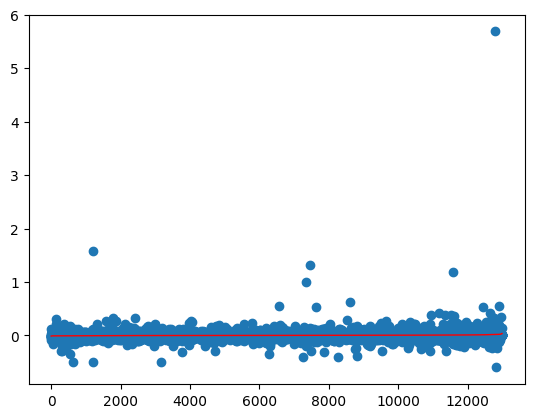

In [61]:
plt.plot(display_df.index.tolist(), display_df.predictions.tolist(), color="red", linewidth=1)
plt.scatter(display_df.index.tolist(), display_df.actual.tolist())
plt.show()

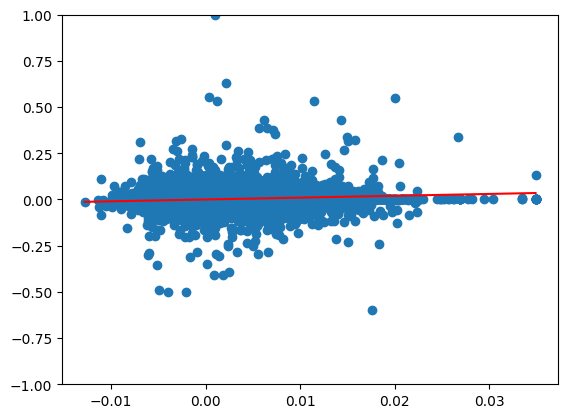

In [62]:
plt.scatter(display_df.predictions.tolist(), display_df.actual.tolist())
plt.plot(display_df.predictions.tolist(), display_df.predictions.tolist(), color="red")
plt.ylim(-1, 1)
plt.show()

In [64]:
def cross_with_actual(df, other_column, num_cuts):
    percentiles = []
    for i in range(num_cuts):
        next_percentile = round(np.nanpercentile(df[other_column], i*100/(num_cuts)), 6)
        if next_percentile not in percentiles:
            percentiles.append(next_percentile)
    percentiles.append(round(max(df[other_column]), 6))

    formatted_ranges, mean_salaries, wins = [], [], []
    for i in range(1, len(percentiles)):
        if i != len(percentiles)-1:
            formatted_ranges.append(f"[{percentiles[i-1]}, {percentiles[i]})")
            mean_salaries.append(round(df[(df[other_column] >= percentiles[i-1]) & (df[other_column] < percentiles[i])].actual.mean(), 6))
            wins.append(round((df[(df[other_column] >= percentiles[i-1]) & (df[other_column] < percentiles[i])].actual >= 0).mean(), 6))
        else:
            formatted_ranges.append(f"[{percentiles[i-1]}, {percentiles[i]}]")
            mean_salaries.append(round(df[(df[other_column] >= percentiles[i-1]) & (df[other_column] <= percentiles[i])].actual.mean(), 6))
            wins.append(round((df[(df[other_column] >= percentiles[i-1]) & (df[other_column] < percentiles[i])].actual >= 0).mean(), 6))
    
    display_df = pd.DataFrame()
    display_df[other_column] = formatted_ranges
    display_df["Actual"] = mean_salaries
    display_df["W/L"] = wins
    return display_df
cross_with_actual(display_df, "predictions", 10)

,predictions,Actual,W/L
0,"[-0.012792, -0.003796)",-0.001528,0.481538
1,"[-0.003796, -0.00245)",0.000024,0.494615
2,"[-0.00245, -0.001527)",-0.000710,0.511932
3,"[-0.001527, -0.000632)",0.000153,0.524653
4,"[-0.000632, 0.000326)",-0.000919,0.525749
5,"[0.000326, 0.001384)",0.001124,0.529638
6,"[0.001384, 0.002724)",-0.000796,0.518462
7,"[0.002724, 0.004536)",-0.000072,0.550769
8,"[0.004536, 0.007561)",0.000410,0.526559
9,"[0.007561, 0.034897]",0.006729,0.623846


In [ ]:
print(display_df[display_df.predictions < 0].actual.agg(["count", "mean", "median"]))
print()
print(display_df[display_df.predictions > 0].actual.agg(["count", "mean", "median"]))

In [58]:
np.mean(errors)

0.024091813473694053

In [55]:
errors = abs(display_df.predictions - display_df.actual).tolist()
errors.sort()
ind = int(len(errors)*0.8)
print(errors[ind])

0.030435381277514308


In [ ]:
importances = xgbc.feature_importances_
feature_names = X_train.columns
feature_importances = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)
final_features = feature_importances.Feature.tolist()[:700]

In [ ]:
final_X_train, final_X_test = X_train[final_features], X_test[final_features]
xgbc_final = XGBRegressor(objective="reg:squarederror")
xgbc_final.fit(final_X_train, y_train, eval_set=[(final_X_test, y_test)], verbose=50)